In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
from PIL import Image
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors

In [2]:
#Reading .csv file containing metadata about the segmentation
print("Reading file containing metadata about the segmentation...")
metadf = pd.read_csv('dataset/categories.csv', sep=',')

#Organizing subcategories into an array, and counting subcategories
subcat = []
no_subcat = 0
for row in metadf.name:
    subcat.append(row)
no_subcat = len(subcat)

#Organizing categories into an array
cat = []
for row in metadf.category:
    cat.append(row)

#Organizing category Ids into an array
catid = []
for row in metadf.catId:
    catid.append(row)
#Counting categories
no_cat = 1
act = catid[0]
categories = [] #array containing categories without duplication
categories.append(cat[0])
for i in range(len(catid)):
    if catid[i]!=act:
        categories.append(cat[i])
        no_cat+=1
        act=catid[i]

#Organizing subcategory RGB colors into an array
col = []
for row in metadf.color:
    c = row.replace(" ", "").split(',')
    rgb = []
    for i in c:
        rgb.append(int(i))
    col.append(rgb)


print('Number of segmentation subcategories:', no_subcat)
print('Number of segmentation categories:', no_cat, "\n")
print("Subcategories and their representational colors [R, G, B]: \n")
for i in range(len(subcat)):
    print("%30s \t" % subcat[i], end ="")
    print(i, "  ", col[i])

Reading file containing metadata about the segmentation...
Number of segmentation subcategories: 41
Number of segmentation categories: 8 

Subcategories and their representational colors [R, G, B]: 

                     unlabeled 	0    [0, 0, 0]
                       dynamic 	1    [111, 74, 0]
                   ego vehicle 	2    [0, 0, 0]
                        ground 	3    [81, 0, 81]
                        static 	4    [0, 0, 0]
                       parking 	5    [250, 170, 160]
                    rail track 	6    [230, 150, 140]
                          road 	7    [128, 64, 128]
                      sidewalk 	8    [244, 35, 232]
                        bridge 	9    [150, 100, 100]
                      building 	10    [70, 70, 70]
                         fence 	11    [190, 153, 153]
                        garage 	12    [180, 100, 180]
                    guard rail 	13    [180, 165, 180]
                        tunnel 	14    [150, 120, 90]
                         wall  

In [3]:
import natsort
#Reading filenames

data_filenames = []
for root, dirs, files in os.walk('dataset/raw_images/'):  
    for filename in files:
        data_filenames.append(filename)

annot_filenames = []
for root, dirs, files in os.walk('dataset/class_color/'):  
    for filename in files:
        annot_filenames.append(filename)
        
data_filenames = natsort.natsorted(data_filenames)
annot_filenames = natsort.natsorted(annot_filenames)

In [4]:
#checking for files in the corresponding folder
catid_annot_filenames = []
for root, dirs, files in os.walk('dataset/catid_annot/'):  
    for filename in files:
        catid_annot_filenames.append('dataset/catid_annot/'+filename)

#if all the annotationfiles exist, there's no need to create them
if len(catid_annot_filenames) == len(annot_filenames):
    print('Subcategory-Id-Annotation Files Already Exist')

#if not, then the .png annotation files should be loaded, 
#the matrices should be created, and they should be serialized
if len(catid_annot_filenames) != len(annot_filenames):
    print('Subcategory-Id-Annotation Files DO NOT Exist')
    for image in range(len(annot_filenames)): #iterationg over annotation-image filenames
        if os.path.exists('dataset/catid_annot/' + data_filenames[image]):
            print("ez mar kesz")
        else:
            print(image)
            filename = annot_filenames[image]
            #loading .png image, converting it to have RGB channels only
            img = np.array(Image.open('dataset/class_color/' + filename).convert('RGB'))
            catid_annot_img = [] #this is gonna be our new matrice
            for i, row in enumerate(img): #iterating over rows
                catid_row = []
                for j, pixel in enumerate(row): #iterating over pixels
                    catid_row.append(col.index(list(row[j]))) #appending the corresponding subcategory id
                catid_annot_img.append(catid_row) 
         
            #saving the matrices
            np.array(catid_annot_img).tofile('dataset/catid_annot/' + data_filenames[image])
    
        #double checking if all the matrices have been serialized    
        for root, dirs, files in os.walk('dataset/catid_annot/'):  
            for filename in files:
                catid_annot_filenames.append('dataset/catid_annot/'+filename)
        if len(catid_annot_filenames) == len(annot_filenames):
            print('OK')

Subcategory-Id-Annotation Files Already Exist


In [5]:
#Splitting data into train-validation-test parts with ratios 70-20-10
print("Splitting data into training data, validation data, test data")
nb_samples=len(data_filenames)
#Splitting ratios:
valid_split = 0.15
test_split = 0.15
train_split = 0.7
print("The ratios are: ")
print("\t train:\t", train_split )
print("\t validation:\t",valid_split )
print("\t test:\t",test_split)
    
#Splitting
#The serialized annotation files are on the same name but in a different directory,
#so we only need to split one of the arrays.
data_train = np.array(data_filenames[0:int(nb_samples*(1-valid_split-test_split))])
data_valid = data_filenames[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
data_test  = data_filenames[int(nb_samples*(1-test_split)):]

print("\nNumber of training samples:\t", len(data_train))
print("Number of validation samples:\t", len(data_valid))
print("Number of test samples:\t", len(data_test))

Splitting data into training data, validation data, test data
The ratios are: 
	 train:	 0.7
	 validation:	 0.15
	 test:	 0.15

Number of training samples:	 700
Number of validation samples:	 150
Number of test samples:	 150


In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib

In [7]:
import cv2
import imageio
import json

In [8]:
from keras.backend.tensorflow_backend import set_session
from keras.utils.np_utils import to_categorical
from keras.applications import imagenet_utils

Using TensorFlow backend.


In [9]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 883892241600398611
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5579735040
locality {
  bus_id: 1
}
incarnation: 5681441471173889420
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:04:00.0, compute capability: 6.1"
]


In [10]:
def preprocess_input(x):
    return imagenet_utils.preprocess_input(x, mode='tf')

In [11]:
catid_annot_img = np.array(Image.open('dataset/catid_annot/'+ data_train[1][:-3] + "png"),dtype=np.int64)
print(catid_annot_img.shape)

(720, 1280)


In [12]:
def data_generator(filenames, batch_size=32, dim=(720, 1280), n_classes=41, shuffle=True):
    # Initialization
    data_size = len(filenames)
    nbatches = data_size // batch_size
    list_IDs = np.arange(data_size)
    indices = list_IDs
    # Data generation
    while True:
        try:
            if shuffle == True:
                np.random.shuffle(indices) #shuffling when Shuffle parameter is True

            for index in range(nbatches):
                batch_indices = indices[index*batch_size:(index+1)*batch_size]

                X = np.empty((batch_size, *dim, 3))
                y_semseg = np.empty((batch_size, *dim), dtype=int)

                for i, ID in enumerate(batch_indices):
                    #reading in the raw image on the fly
                    image = cv2.resize(np.array(Image.open('dataset/raw_images/' + filenames[ID]), dtype=np.uint8), dim[1::-1])
                    #loading in the serialized annotation file on the fly
                    catid_annot_img = np.array(Image.open('dataset/catid_annot/'+ filenames[ID][:-3] + "png"),dtype=np.int64)
                    catid_annot_img = np.reshape(catid_annot_img, (720, 1280))
                    label = cv2.resize(catid_annot_img, dim[1::-1], interpolation=cv2.INTER_NEAREST)

                    X[i,] = image
                    y_semseg[i] = label

                yield (preprocess_input(X), to_categorical(y_semseg, num_classes=n_classes))
        except StopIteration as e:
            print(e)
            break

In [13]:
#Parameters for the data generator
batch_size = 2
data_shape= np.array(Image.open('dataset/raw_images/' + data_train[0])).shape[:2]
data_shape= (int(data_shape[0]/2), int(data_shape[1]/2))
print(data_shape)
classes = no_subcat

(360, 640)


In [14]:
#Creating a data generator for training and validating
train_generator = data_generator(data_train, batch_size=batch_size, dim=data_shape, n_classes=classes)
val_generator = data_generator(data_valid, batch_size=batch_size, dim=data_shape, n_classes=classes)
test_generator = data_generator(data_test, batch_size=batch_size, dim=data_shape, n_classes=classes)

An example of the training data generated by the training data generator:


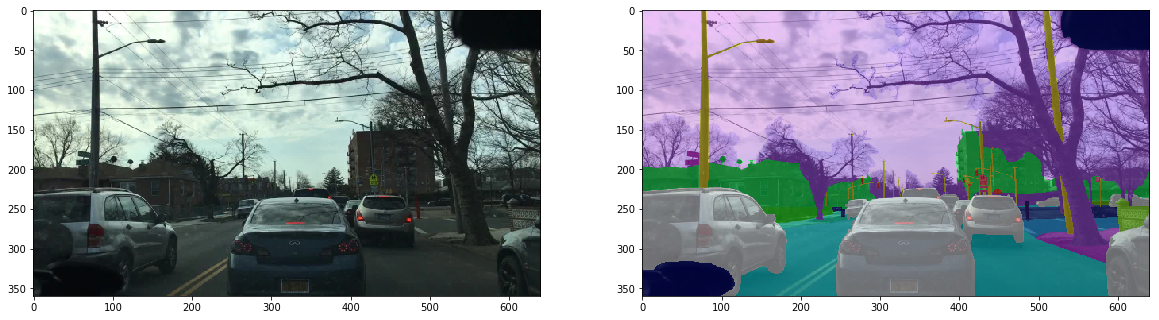

In [15]:
#Testing the train generator
print("An example of the training data generated by the training data generator:")
i = 0
image, label = next(train_generator)
image = image[i]
label = np.argmax(label[i], axis=-1)

fig=plt.figure(figsize=(20, 10))

cm = plt.get_cmap('gist_ncar')

fig.add_subplot(1, 2, 1)
plt.imshow(image * .5 + .5)
fig.add_subplot(1, 2, 2)
plt.imshow((image * .5 + .5) * .6 + cm(label/34.)[...,:3] * .4)
plt.show()

In [16]:
import keras.models as models
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K

In [17]:
import keras
from keras import optimizers

def get_unet_128_ulite(input_shape=(360, 640, 3),
                 num_classes=41, optimizer='adam'):
    inputs = Input(shape=input_shape)
    # 128
 
    down1 = Conv2D(64, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64
 
    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32
 
    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
 
    # 16
 
    # 16
 
    up3 = Conv2D(256, (3, 3), padding='same')(down3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32
 
    up2 = UpSampling2D((2, 2))(up3)
    up2 = keras.layers.concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64
 
    up1 = UpSampling2D((2, 2))(up2)
    up1 = keras.layers.concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128
 
    classify = Conv2D(num_classes, (1, 1), padding='valid')(up1)
    classify = Activation('softmax')(classify)
 
    model = Model(inputs=inputs, outputs=classify)
    model.compile(loss='categorical_crossentropy',
                  optimizer= optimizer,
                  metrics=['accuracy'])
 
    return model

In [18]:
#Defining the model
semseg_model = get_unet_128_ulite()

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = 'model_weights/model.{epoch:02d}-{val_loss:.4f}.hdf5'
early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 8)
checkpoint_callback = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

In [23]:
history = semseg_model.fit_generator(generator = train_generator,
                                     steps_per_epoch = len(data_train) // batch_size,
                                     epochs = 50, 
                                     validation_data = val_generator,
                                     validation_steps = len(data_valid) // batch_size,
                                     callbacks = [early_stopping_callback, checkpoint_callback],
                                     verbose = 2)

Epoch 1/50
 - 338s - loss: 1.7672 - acc: 0.5222 - val_loss: 1.8115 - val_acc: 0.5085
Epoch 2/50
 - 327s - loss: 1.5067 - acc: 0.5729 - val_loss: 1.6122 - val_acc: 0.5191
Epoch 3/50
 - 319s - loss: 1.4435 - acc: 0.5945 - val_loss: 1.6075 - val_acc: 0.5499
Epoch 4/50
 - 316s - loss: 1.3980 - acc: 0.6064 - val_loss: 1.4705 - val_acc: 0.5624
Epoch 5/50
 - 316s - loss: 1.3190 - acc: 0.6303 - val_loss: 1.3293 - val_acc: 0.6214
Epoch 6/50
 - 316s - loss: 1.2738 - acc: 0.6464 - val_loss: 1.2737 - val_acc: 0.6467
Epoch 7/50
 - 315s - loss: 1.2440 - acc: 0.6556 - val_loss: 1.2639 - val_acc: 0.6506
Epoch 8/50
 - 315s - loss: 1.1930 - acc: 0.6708 - val_loss: 1.3054 - val_acc: 0.6285
Epoch 9/50
 - 315s - loss: 1.1708 - acc: 0.6740 - val_loss: 1.3032 - val_acc: 0.6354
Epoch 10/50
 - 316s - loss: 1.1391 - acc: 0.6861 - val_loss: 1.1894 - val_acc: 0.6705
Epoch 11/50
 - 316s - loss: 1.1136 - acc: 0.6945 - val_loss: 1.1160 - val_acc: 0.7023
Epoch 12/50
 - 316s - loss: 1.0821 - acc: 0.7016 - val_loss: 1.

KeyboardInterrupt: 

In [24]:
semseg_model.load_weights('model_weights/model.36-0.9417.hdf5')

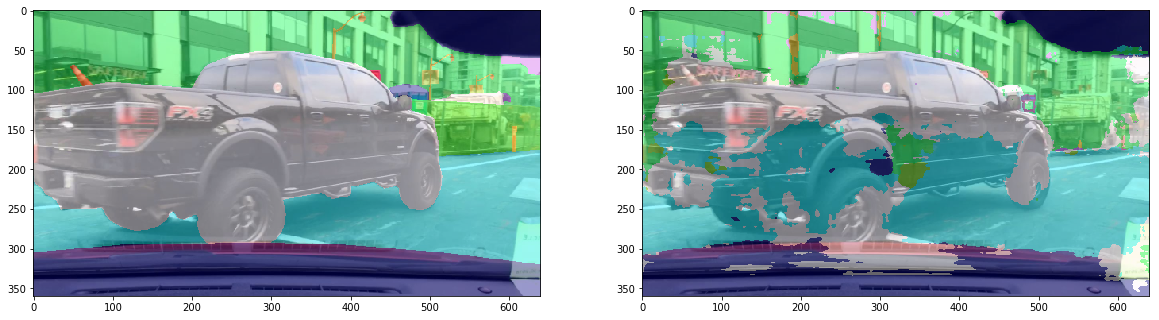

In [33]:
i = 0
image, label = next(val_generator)
label = np.argmax(label[i], axis=-1)

pred = semseg_model.predict(image)
pred = np.argmax(pred[0], axis=-1)
fig=plt.figure(figsize=(20, 10))

cm = plt.get_cmap('gist_ncar')
image = image[i]

fig.add_subplot(1, 2, 1)
plt.imshow((image * .5 + .5) * .6 + cm(label/34.)[...,:3] * .4)
fig.add_subplot(1, 2, 2)
plt.imshow((image * .5 + .5) * .6 + cm(pred/34.)[...,:3] * .4)
plt.show()

In [34]:
acc = semseg_model.evaluate_generator(test_generator, len(data_test))
print(semseg_model.metrics_names)
print(acc)

['loss', 'acc']
[0.949074412782987, 0.743104657928149]
